In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
])

trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

### calculating the loss

In [2]:
# Creating the model
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10)
                     )

# Defining the Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

# Calculating the Logits
logits = model(images)

# Calculating the Loss
loss = criterion(logits, labels)

print(loss)

tensor(2.3178, grad_fn=<NllLossBackward>)


### Using NLLLoss with log softmax output

In [3]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1)
)

criterion = nn.NLLLoss()

images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)

loss = criterion(logits, labels)
print(loss)

tensor(2.2990, grad_fn=<NllLossBackward>)


### Autograd- Working with Gradients

Now that we know how to calculate a loss, how do we use it to perform backpropagation? Torch provides a module, autograd, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad=True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

---

You can turn off gradients for a block of code with the `torch.no_grad()`

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`

The gradients are computed with respect to some variable z with `z.backward()`. This does a backward pass through the operations that created z.

In [4]:
x = torch.randn(2, 2, requires_grad=True)
print(x)

tensor([[ 0.2477,  1.0298],
        [-1.9966,  0.6522]], requires_grad=True)


In [5]:
y = x**2
print(y)

tensor([[0.0614, 1.0604],
        [3.9863, 0.4254]], grad_fn=<PowBackward0>)


In [6]:
# operation done for gradient
print(y.grad_fn)

In [7]:
z = y.mean()
print(z)

tensor(1.3834, grad_fn=<MeanBackward0>)


In [8]:
# since we haven't still invoked the backwards method, the gradients are not yet calculated, therefore are empty
print(x.grad)

None


While calculating mathematically, the gradient of *z* with respect to *x* is:

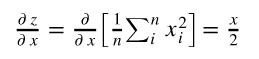

In [9]:
# computing the gradient
z.backward()
# this computes gradient of z w.r.t. x
print(x.grad)
print(x/2)

tensor([[ 0.1239,  0.5149],
        [-0.9983,  0.3261]])
tensor([[ 0.1239,  0.5149],
        [-0.9983,  0.3261]], grad_fn=<DivBackward0>)


### Using Loss and Autograd Together

The gradients from the loss is used for updating the weights

In [10]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1)
                     )

criterion = nn.NLLLoss()

images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)

loss = criterion(logits, labels)
print(loss)

tensor(2.3214, grad_fn=<NllLossBackward>)


In [11]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0041, -0.0041, -0.0041,  ..., -0.0041, -0.0041, -0.0041],
        [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [ 0.0046,  0.0046,  0.0046,  ...,  0.0046,  0.0046,  0.0046],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003]])


### Optimizers

In [12]:
from torch import optim

optimizer = optim.SGD(model.parameters(), lr=0.01)

The general steps in  pytorch for training:

- Make a forward pass through the network
- Use the network output to calculate the loss
- Perform a backward pass through the network with `loss.backward()` to calculate the gradients
- Take a step with the optimizer to update the weights

In [13]:
print("initial weights: \n", model[0].weight)

images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

# Pytorch by default accumulates the gradients by summing them up
# therefore we need to clear all those gradients first
optimizer.zero_grad()

# Forward pass
op = model(images)
loss = criterion(op, labels)
loss.backward()
print('\nGradient: \n', model[0].weight.grad)

initial weights: 
 Parameter containing:
tensor([[-0.0197, -0.0323,  0.0153,  ...,  0.0176,  0.0260,  0.0187],
        [-0.0271,  0.0114, -0.0140,  ..., -0.0346,  0.0087, -0.0087],
        [-0.0254,  0.0135, -0.0055,  ...,  0.0351,  0.0182,  0.0037],
        ...,
        [ 0.0044, -0.0280, -0.0007,  ...,  0.0119,  0.0131, -0.0178],
        [ 0.0098, -0.0295, -0.0099,  ..., -0.0319,  0.0003,  0.0247],
        [-0.0269,  0.0033,  0.0271,  ..., -0.0355, -0.0090,  0.0197]],
       requires_grad=True)

Gradient: 
 tensor([[-0.0041, -0.0041, -0.0041,  ..., -0.0041, -0.0041, -0.0041],
        [ 0.0012,  0.0012,  0.0012,  ...,  0.0012,  0.0012,  0.0012],
        [ 0.0025,  0.0025,  0.0025,  ...,  0.0025,  0.0025,  0.0025],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004],
        [ 0.0011,  0.0011,  0.0011,  ...,  0.0011,  0.0011,  0.0011]])


In [14]:
# Updating the weights
optimizer.step()
print('Updated weights: \n', model[0].weight)

Updated weights: 
 Parameter containing:
tensor([[-0.0197, -0.0323,  0.0153,  ...,  0.0176,  0.0261,  0.0187],
        [-0.0271,  0.0114, -0.0140,  ..., -0.0346,  0.0086, -0.0087],
        [-0.0254,  0.0135, -0.0055,  ...,  0.0351,  0.0181,  0.0037],
        ...,
        [ 0.0044, -0.0280, -0.0007,  ...,  0.0119,  0.0131, -0.0178],
        [ 0.0098, -0.0295, -0.0099,  ..., -0.0319,  0.0003,  0.0247],
        [-0.0269,  0.0032,  0.0271,  ..., -0.0355, -0.0090,  0.0197]],
       requires_grad=True)


### Training the model

In [15]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        images = images.view(images.shape[0], -1)
    
        optimizer.zero_grad()
        
        op = model(images)
        loss = criterion(op, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.8673890319460236
Training loss: 0.827770696075232
Training loss: 0.5283979232123157
Training loss: 0.4309013792033643
Training loss: 0.38518756535897125


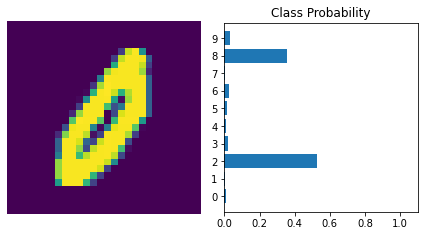

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)